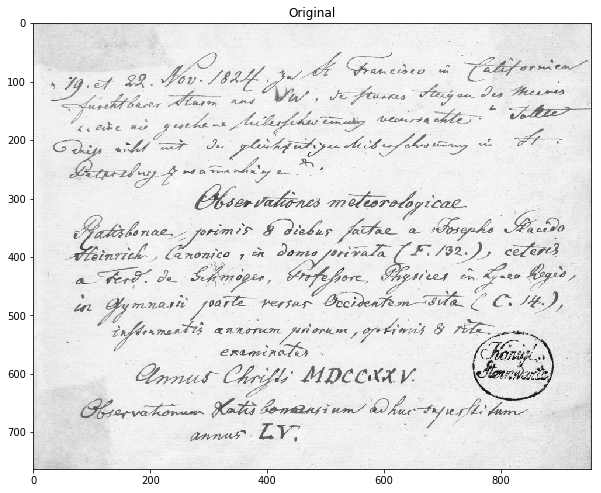

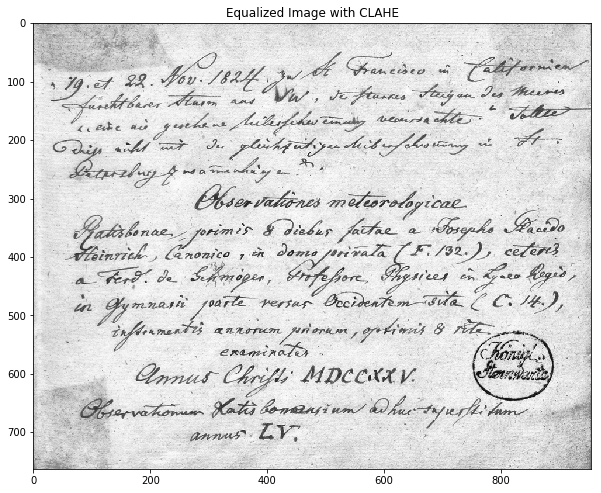

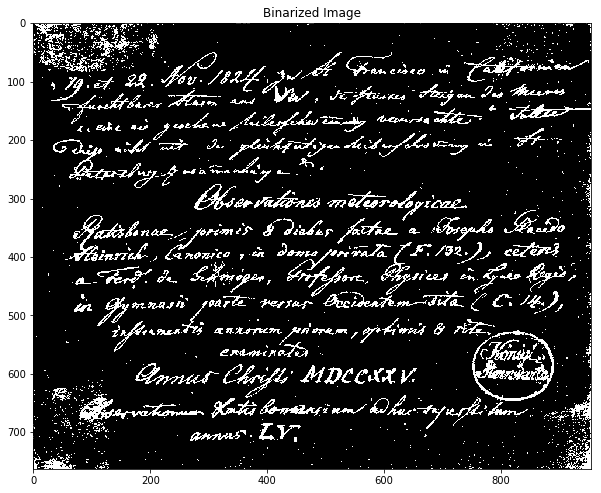

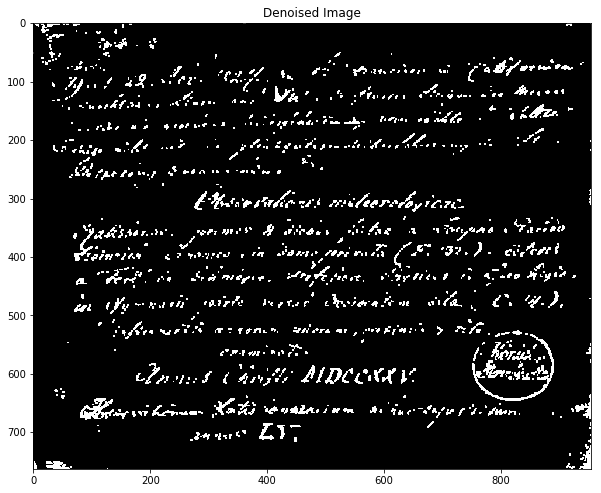

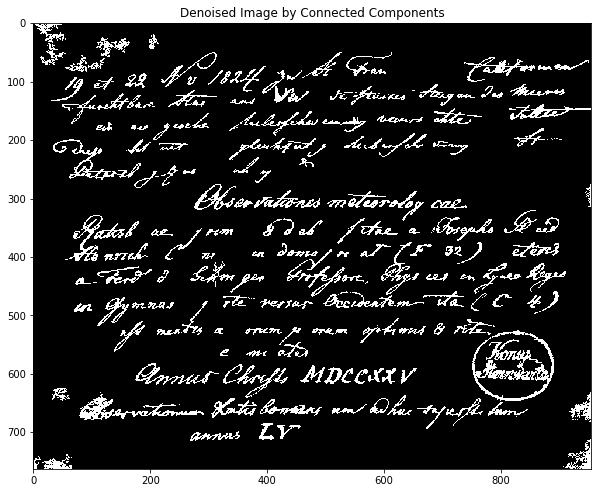

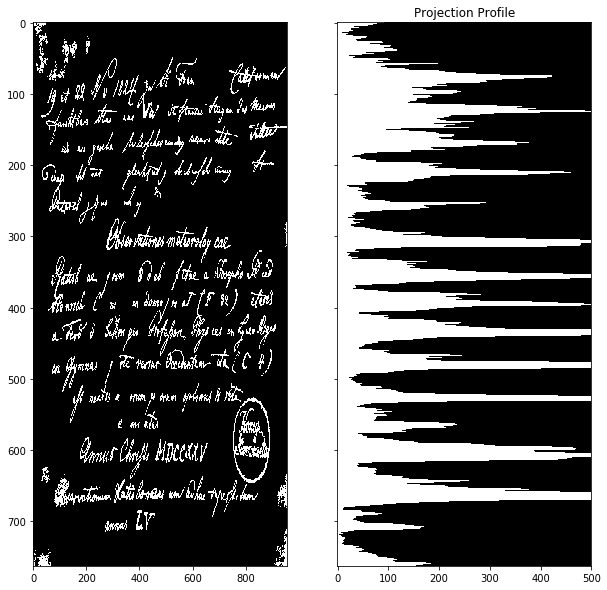

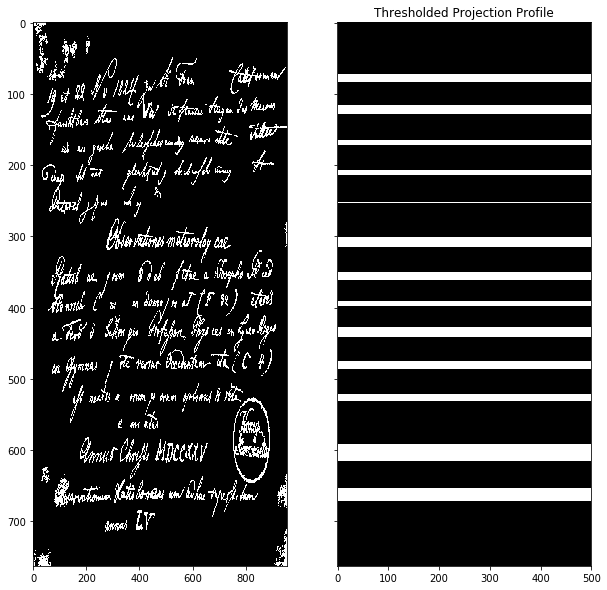

The average line height is 11.615384615384615


In [23]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.cluster.hierarchy as hcluster
import sklearn.cluster as cluster


def load_image(path: str):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def show_image(image, title=''):
    figure, axis = plt.subplots(figsize=(10,10))
    axis.imshow(image, cmap='Greys_r')
    plt.title(title)
    plt.show()
    
    
def show_images(images, title=''):
    figure, (axis1, axis2) = plt.subplots(1, len(images), sharey=True, figsize=(10,10))
    
    axis1.imshow(images[0], cmap='Greys_r', aspect='auto')
    axis2.imshow(images[1], cmap='Greys_r', aspect='auto')
    
    plt.title(title)
    plt.show()
    

def invert(img):
    return cv2.bitwise_not(img)


def binarize_image(img):   
    ret, img_binarized = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return img_binarized


def equalize_image(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)
    
    
def get_projection_profile(img):
    return np.sum(img, 1)


def threshold_projection_profile(projection):
    projection_scaled = np.interp(projection, (projection.min(), projection.max()), (0,1))
    
    threshold = 0.3
    threshold_indices = projection_scaled > threshold
    
    projection_scaled.fill(0)
    projection_scaled[threshold_indices] = 1
    
    return projection_scaled


def calculate_line_height(projection):
    change_indices = np.where(projection[:-1] != projection[1:])[0]
    
    heights = []
    for (index, change_index) in enumerate(change_indices):
        change_index_prev = 0 if index == 0 else change_indices[index - 1]
        
        if projection[change_index] == 1:
            height = change_index - change_index_prev
            heights.append(height)
    
    return np.mean(heights)

    
def get_image_of_projection_profile(projection, img):
    projection = np.interp(projection, (projection.min(), projection.max()), (0,1))
    
    maximum = np.max(projection)
    width = img.shape[1]
    result = np.zeros((projection.shape[0], 500))
    
    for row in range(img.shape[0]):
        cv2.line(result, (0, row), (int(projection[row]*width/maximum), row), (255,255,255), 1)
        
    return result
    

def apply_morphology(img):
    kernel = np.ones((3,3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    
    
def remove_connected_components(img):
    number_of_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, 8, cv2.CV_32S)
    sizes = stats[1:, -1] 
    number_of_labels = number_of_labels - 1
    min_size = 100 
    
    img_cleaned = np.full(img.shape, 0)
    for i in range(0, number_of_labels):
        if sizes[i] >= min_size:
            img_cleaned[labels == i + 1] = 255
            
    return img_cleaned


def run():
    img_path = "./assets/scan.png"
    img = load_image(img_path)
    
    if img is None:
        return
    
    show_image(img, 'Original')
    
    img_equalized = equalize_image(img.copy())
    show_image(img_equalized, 'Equalized Image with CLAHE')
    
    img_binarized =  binarize_image(img_equalized.copy())
    img_binarized = invert(img_binarized)
    show_image(img_binarized, 'Binarized Image')
    
    img_denoised = apply_morphology(img_binarized.copy())
    show_image(img_denoised, 'Denoised Image')
    
    img_denoised_cc = remove_connected_components(img_binarized.copy())
    show_image(img_denoised_cc, 'Denoised Image by Connected Components')
    
    projection_profile = get_projection_profile(img_denoised_cc)
    img_profile = get_image_of_projection_profile(projection_profile, img_denoised_cc)
    show_images([img_denoised_cc, img_profile], 'Projection Profile')
    
    projection_profile_thresholded = threshold_projection_profile(projection_profile)
    img_profile_thresholded = get_image_of_projection_profile(projection_profile_thresholded, img_denoised_cc)
    show_images([img_denoised_cc, img_profile_thresholded], 'Thresholded Projection Profile')
    
    line_height = calculate_line_height(projection_profile_thresholded)
    
    print("The average line height is {}".format(line_height))

     
run()